# Подбор гиперпараметров модели на примере [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)

## 1. **Вводные данные**

Наша практика будет основана на соревновании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа). Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776). 

[Данные](https://lms.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_train_sem09__1_.zip) представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец **Activity** содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (**GridSeachCV**, **RandomizedSearchCV**, **Hyperopt**, **Optuna**) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import cross_val_score # кросс валидации

%matplotlib inline
plt.style.use('seaborn')

Загрузим даннные и выведем пять строк датасета:

**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1TlCdFMDFofyN7EIrIzXwwjcMBo4yHb1a'

In [2]:
train_dnk_zip = pd.read_csv('_train_sem09__1_.zip')
train_dnk = train_dnk_zip.copy()
train_dnk.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Смотрим на сбалансированность классов:

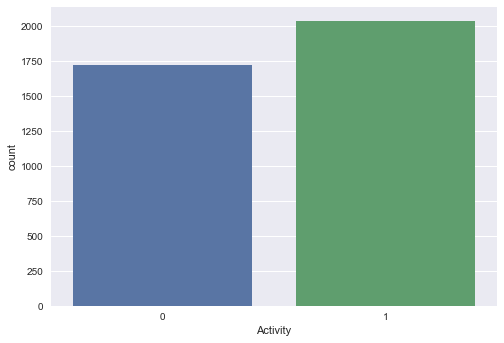

In [84]:
sns.countplot(data=train_dnk, x='Activity'); 

Классы относительно сбалансированы. Сразу выделим из датасета целевой признак **Activity**. Будем использовать кросс-валидацию (cross validation) на пяти холдах.

In [3]:
X = train_dnk.drop('Activity', axis=1)
y = train_dnk['Activity']

## 2. **Логистическая регрессия(LogisticRegression) Baseline**

Для начала применим модель логистической регрессии. Целевой признак является бинарным. Все параметры оставим по умолчанию.

In [86]:
%%time
# создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=1000 ,random_state=42)
# сбучаем модель, минимизируя logloss
score_log = cross_val_score(log_reg, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1 for test data={score_log:.3f}')

F1 for test data=0.776
CPU times: total: 62.5 ms
Wall time: 14.9 s


Итак базовая модель логистической регрессии дала метрику F1 на тестовых данных 0,776. Попробуем использовать модель случайный лес.

## 3. **Случайный лес(Random Forest) BaseLine**

Случайный лес (Random Forest) — это самая распространённая реализация бэггинга, основанная на использовании в качестве базовой модели дерева решений. 

In [87]:
%%time
# создаем объект класса Random Forest
random_reg = ensemble.RandomForestClassifier(random_state=42)
# обучаем модель
score_reg = cross_val_score(random_reg, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
# выводим метрики
print(f'F1 for test data={score_reg:.3f}')

F1 for test data=0.813
CPU times: total: 46.9 ms
Wall time: 4.5 s


Базовая модель Random Forest дала результат метрики на тестовых данных F1=0.813, что значительно лучше, чем модель логистической регрессии. 

Далее будем подбирать поочерёдно гиперпараметры моделей разными методами: **GridSearchCV**, **RandomizedSearchCV**, **Hyperopt**, **Optuna**.

## 4. **GridSearchCV**

Наиболее часто используемый метод — это поиск по сетке (grid search), который по сути является попыткой перебрать все возможные комбинации заданных гиперпараметров. Мы указываем список значений для различных гиперпараметров, и, ориентируясь на нашу метрику, оцениваем эффективность модели для каждого их сочетания, чтобы получить оптимальную комбинацию значений.

Основные параметры [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

- **estimator** — алгоритм, который будем оптимизировать;
- **param_grid** — словарь или список словарей. Словарь с именами гиперпараметров (в формате строки (str), например, 'max_depth') в качестве ключей и списками параметров (например, [5, 8, 10]) в качестве значений. Итого: {'max_depth': [5, 8, 10] }.

*Важно помнить, что выбор алгоритма оптимизации зависит от выбранного типа штрафа:*
- 'newton-cg' - ['l2', 'none']
- 'lbfgs' - ['l2', 'none']
- 'liblinear' - ['l1', 'l2']
- 'sag' - ['l2', 'none']
- 'saga' - [elasticnet', 'l1', 'l2', 'none']

- **scoring** — по умолчанию используется score-функция заданного алгоритма:
- для классификации — sklearn.metrics.accuracy_score;
- для регрессии — sklearn.metrics.r2_score;

- **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
- **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.

### 4.1 Логистическая регрессия(LogisticRegression) c подборкой гиперпараметров методом GridSearchCV

In [4]:
%%time
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'], # алгоритм оптимизации
               'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
              
              {'penalty': ['elasticnet', 'none'],
              'solver': ['saga'],
              'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              'l1_ratio': np.arange(0, 1, 0.1, dtype=float).tolist()} # параметр смешивания Elastic-Net 0 <= l1_ratio <= 1, обязателен, если penalty='elasticnet'
]

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость по условию
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X, y) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')

Best Hyperparameter Values: {'C': 0.05, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Models:LogisticRegression(C=0.05, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
Best score Cross validation: 0.792
CPU times: total: 33.6 s
Wall time: 5h 46min 5s


- Best Hyperparameter Values: {'C': 0.05, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
- Best Models:LogisticRegression(C=0.05, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
- Best score Cross validation: 0.792

CPU times: total: 33.6 s

Wall time: 5h 46min 5s

По сравнению с базовой моделью Логистической регрессии(LogisticRegression) метрику F1 удалось поднять до 0,792(с 0,776) благодаря подбору гиперпараметров методом **GridSearchCV**.

**Модель выдала следующие лучшие параметры: Best Hyperparameter Values: {'C': 0.05, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}**

### 4.2 Случайный лес(Random Forest) c подборкой гиперпараметров методом GridSearchCV

In [89]:
%%time
# задаём сетку параметров
param_grid_for = {'n_estimators': list(range(50, 200, 30)), # количество деревьев в лесу
              'min_samples_leaf': list(range(1, 6, 1)),
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)), # максимальная глубина одного дерева
              'criterion': ['gini', 'entropy'] # критерий информативности разбиения для каждого из деревьев
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid_for, 
    cv=5, 
    n_jobs = -1,
    scoring='f1'
)  
 
grid_search_forest.fit(X, y)

print(f'Best Hyperparameter Values: {grid_search_forest.best_params_}')
print(f'Best Models:{grid_search_forest.best_estimator_}')
print(f'Best score Cross validation: {grid_search_forest.best_score_:.3f}')

Best Hyperparameter Values: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 110}
Best Models:RandomForestClassifier(max_depth=17, min_samples_leaf=2, n_estimators=110,
                       random_state=42)
Best score Cross validation: 0.816
CPU times: total: 5.22 s
Wall time: 10min 25s


- **Best Hyperparameter Values**: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 110}
- **Best Models**:RandomForestClassifier(max_depth=17, min_samples_leaf=2, n_estimators=110,
                       random_state=42)
- **Best score Cross validation**: 0.816

CPU times: total: 5.22 s
Wall time: 10min 25s

По сравнению с базовой моделью Случайный лес(Random Forest) метрика F1 практически осталось на том же уровне 0,816( в базовой - 0,813) при лучших подобранных гиперпараметров методом **GridSearchCV**.

**Модель выдала следующие лучшие параметры: Best Hyperparameter Values: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 170}**

## 5. **RandomizedSearchCV**

В отличие от **GridSearchCV**, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается **n_iter**.

[**RandomizedSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) выбирает n (количество задаем сами) случайных точек/комбинаций из заданных нами последовательностей. Как следствие, скорость сходимости к минимуму функции становится выше.
Основные параметры RandomizedSearchCV аналогичны GridSearchCV, за исключением **n_iter** -  количество комбинаций на расчёт. От этого параметра напрямую зависит время оптимизации и качество модели.

С использованием класса **RandomizedSearchCV** из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии и случайного лес.

### 5.1 Логистическая регрессия(LogisticRegression) c подборкой гиперпараметров методом RandomizedSearchCV

In [90]:
%%time
from sklearn.model_selection import RandomizedSearchCV
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
""" param_random = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))} """

param_random = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'], # алгоритм оптимизации
               'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
              
              {'penalty': ['elasticnet', 'none'],
              'solver': ['saga'],
              'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              'l1_ratio': np.arange(0, 1, 0.1, dtype=float).tolist()} # параметр смешивания Elastic-Net 0 <= l1_ratio <= 1, обязателен, если penalty='elasticnet'
]
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_random, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1,
    scoring='f1'   
)  
random_search.fit(X, y) 
print(f'Best Hyperparameter Values: {random_search.best_params_}')
print(f'Best Models:{random_search.best_estimator_}')
print(f'Best score Cross validation: {random_search.best_score_:.3f}')

Best Hyperparameter Values: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.30000000000000004, 'C': 0.05}
Best Models:LogisticRegression(C=0.05, l1_ratio=0.30000000000000004, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')
Best score Cross validation: 0.787
CPU times: total: 18.3 s
Wall time: 47min 29s


- **Best Hyperparameter Values**: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.30000000000000004, 'C': 0.05}
- **Best Models**:LogisticRegression(C=0.05, l1_ratio=0.30000000000000004, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')
- **Best score Cross validation**: 0.787

CPU times: total: 18.3 s
Wall time: 47min 29s

Выбирая гиперпараметры методом **RandomizedSearchCV** Логистической регрессии(LogisticRegression) удалось улучшить метрику F1 до 0,787, что улучшило базовый результат(0,776) и практически на одном уровне с подборкой гиперпараметров методом **GridSearchCV**(0,795), но благодаря этому методу мы сэкономили время поиска лучших параметров.

**Модель выдала следующие лучшие параметры: Best Hyperparameter Values: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.30000000000000004, 'C': 0.05}**

### 5.2 Случайный лес(Random Forest) c подборкой гиперпараметров методом RandomizedSearchCV

In [91]:
%%time
from sklearn.model_selection import RandomizedSearchCV
param_random_for = {'n_estimators': list(range(50, 200, 30)), # количество деревьев в лесу
              'min_samples_leaf': list(range(1, 6, 1)),
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)), # максимальная глубина одного дерева
              'criterion': ['gini', 'entropy'] # критерий информативности разбиения для каждого из деревьев
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_random_for, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1,
    scoring='f1'
)  
random_search_forest.fit(X, y) 

print(f'Best Hyperparameter Values: {random_search_forest.best_params_}')
print(f'Best Models:{random_search_forest.best_estimator_}')
print(f'Best score Cross validation: {random_search_forest.best_score_:.3f}')

Best Hyperparameter Values: {'n_estimators': 140, 'min_samples_leaf': 3, 'max_depth': 17, 'criterion': 'entropy'}
Best Models:RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=3,
                       n_estimators=140, random_state=42)
Best score Cross validation: 0.815
CPU times: total: 3.39 s
Wall time: 2min 7s


- **Best Hyperparameter Values**: {'n_estimators': 140, 'min_samples_leaf': 3, 'max_depth': 17, 'criterion': 'entropy'}
- **Best Models**: RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=3,
                       n_estimators=140, random_state=42)
- **Best score Cross validation**: 0.815

CPU times: total: 3.39 s

Wall time: 2min 7s

Метрика F1, полученная при подборе гиперпараметров методом **RandomizedSearchCV** осталось практически на том же уровне - 0,815 как и по **GridSearchCV** и с аналогичным набором параметров, но время поиска параметров уменьшилось до 2min 7s. Метрика по сравнению с базовой моделью(0,813) ненамного улучшилась.

**Модель выдала следующие лучшие параметры: Best Hyperparameter Values: {'n_estimators': 140, 'min_samples_leaf': 3, 'max_depth': 17, 'criterion': 'entropy'}**

## 6. **Hyperopt**

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 

Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

Существует несколько разных алгоритмов для этого типа оптимизации, но особенно используемым является [Tree-Structured Parzen Estimators (TPE)](https://orion.readthedocs.io/en/stable/code/algo/tpe.html).

[**Hyperopt**](https://github.com/hyperopt/hyperopt/) — это библиотека Python с открытым исходным кодом на основе байесовской оптимизации, в которой реализован алгоритм Tree-Structured Parzen Estimators (TPE).

Три шага для использования Hyperopt:

1. Задание пространства поиска гиперпараметров. 

Объявляем список гиперпараметров, тип распределения и его границы.

Основные типы:

- **hp.choice(label, options)** #равновероятный выбор из множества

- **hp.randint(label, upper)** #случайное целое число; random seed, например 

- **hp.uniform(label, low, high)** #равномерное непрерывное распределение

- **hp.normal(label, mu, sigma)** #нормальное непрерывное распределение

- **hp.lognormal(mu, sigma)** #логнормальное непрерывное распределение

- категориальных — hp.choice;
- целочисленных —  hp.randit, hp.quniform;
- непрерывных — аналогично целочисленным и hp.normal, hp.uniform, hp.lognormal, hp.loguniform.

Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики. Можем минимизировать/максимизировать значение метрики.

3. Задание алгоритма поиска:

- Random Search.
- Tree of Parzen Estimators (TPE).

### 6.1 Логистическая регрессия(LogisticRegression) c подборкой гиперпараметров методом Hyperopt

In [92]:
#делаем импорт и выведем версию библиотеки
from click import option
from requests import options
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

Интерфейс Hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации. Она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [93]:
# зададим пространство поиска гиперпараметров - получится 3 набора, так как для каждого типа регуляции подходят только определённые алгоритмы оптимизации
space_1 = {'penalty': hp.choice(label='penalty', options=['l2', 'none']) , # тип регуляризации
              'solver': hp.choice(label='solver', options=['lbfgs', 'sag', 'newton-cg']), # алгоритм оптимизации
              'C': hp.uniform('C', 0.01, 1)
              } # алгоритм оптимизации
             
              
space_2 = {'penalty': hp.choice('penalty', ['l1', 'l2']) ,
              'solver': hp.choice('solver', ['liblinear', 'saga']),
              'C': hp.uniform('C', 0.01, 1)
              }
    
space_3 = {'penalty': hp.choice('penalty', ['elasticnet', 'none']),
              'solver': hp.choice('solver', ['saga']),
              'C': hp.uniform('C', 0.01, 1),
              'l1_ratio': hp.uniform('l1_ratio', 0, 1)} # параметр смешивания Elastic-Net 0 <= l1_ratio <= 1, обязателен, если penalty='elasticnet'  

# зафиксируем random_state
random_state = 42

def hyperopt(space, cv=5, X=X, y=y, random_state=random_state):
    """ Функция, обучающая модель LogisticRegression
    по переданным гиперпараметрам

    Args:
        space (dict): набор гиперпараметров
        cv (int, optional=5): Количество холдов кросс-валидации. Defaults to 5.
        X (DataFrame): DataFrame с признаками. Defaults to X_train.
        y (Series): Series с целевым признаком. Defaults to y_train.
        random_state (int): Рандомное число для воспроизводимости результата. Defaults to random_state.

    Returns:
        score(float): метрика F1
    """
    try:
        model=linear_model.LogisticRegression(
        penalty = space['penalty'],
        solver = space['solver'],
        C=np.abs(float(space['C'])),
        l1_ratio=float(space['l1_ratio']),
        random_state=random_state,
        max_iter=50        
    )        
    except KeyError:
          
        model=linear_model.LogisticRegression(
        penalty = space['penalty'],
        solver = space['solver'],
        C=np.abs(float(space['C'])),
        random_state=random_state,
        max_iter=50
           )
        
     
    # применим  cross validation 
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

Подбираем лучшие гиперпараметры для первого набора:

In [94]:
%%time
              
trials = Trials() # используется для логирования результатов  

best_1=fmin(hyperopt, # наша функция 
          space=space_1, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best_1}')
print(f'Наилучшие значения гиперпараметров {space_eval(space_1, best_1)}')

100%|██████████| 50/50 [07:07<00:00,  8.55s/trial, best loss: -0.7916411179230474]
Наилучшие значения гиперпараметров {'C': 0.028670415126948956, 'penalty': 0, 'solver': 0}
Наилучшие значения гиперпараметров {'C': 0.028670415126948956, 'penalty': 'l2', 'solver': 'lbfgs'}
CPU times: total: 2.55 s
Wall time: 7min 7s


Лучшие значения для первого набора:

- Наилучшие значения гиперпараметров {'C': 0.028670415126948956, 'penalty': 0, 'solver': 0}
- Наилучшие значения гиперпараметров {'C': 0.028670415126948956, 'penalty': 'l2', 'solver': 'lbfgs'}

CPU times: total: 2.55 s

Wall time: 7min 7s

Подбираем лучшие гиперпараметры для второго набора:

In [95]:
%%time
              
trials = Trials() # используется для логирования результатов
  

best_2=fmin(hyperopt, # наша функция 
          space=space_2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best_2}')
print(f'Наилучшие значения гиперпараметров {space_eval(space_2, best_2)}')

100%|██████████| 50/50 [05:06<00:00,  6.13s/trial, best loss: -0.7891514597312479]
Наилучшие значения гиперпараметров {'C': 0.21891904268225607, 'penalty': 0, 'solver': 1}
Наилучшие значения гиперпараметров {'C': 0.21891904268225607, 'penalty': 'l1', 'solver': 'saga'}
CPU times: total: 2.61 s
Wall time: 5min 6s


Лучшие значения для второго набора:

- Наилучшие значения гиперпараметров {'C': 0.21891904268225607, 'penalty': 0, 'solver': 1}
- Наилучшие значения гиперпараметров {'C': 0.21891904268225607, 'penalty': 'l1', 'solver': 'saga'}

CPU times: total: 2.61 s
Wall time: 5min 6s

Подбираем лучшие гиперпараметры для третьего набора:

In [96]:
%%time
              
trials = Trials() # используется для логирования результатов
  

best_3=fmin(hyperopt, # наша функция 
          space=space_3, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best_3}')
print(f'Наилучшие значения гиперпараметров {space_eval(space_3, best_3)}')

100%|██████████| 50/50 [07:07<00:00,  8.55s/trial, best loss: -0.7891514597312479]
Наилучшие значения гиперпараметров {'C': 0.21621913437384038, 'l1_ratio': 0.9950762402547877, 'penalty': 0, 'solver': 0}
Наилучшие значения гиперпараметров {'C': 0.21621913437384038, 'l1_ratio': 0.9950762402547877, 'penalty': 'elasticnet', 'solver': 'saga'}
CPU times: total: 2.55 s
Wall time: 7min 7s


Лучшие значения для третьего набора:

- Наилучшие значения гиперпараметров {'C': 0.21621913437384038, 'l1_ratio': 0.9950762402547877, 'penalty': 0, 'solver': 0}
- Наилучшие значения гиперпараметров {'C': 0.21621913437384038, 'l1_ratio': 0.9950762402547877, 'penalty': 'elasticnet', 'solver': 'saga'}

CPU times: total: 2.55 s

Wall time: 7min 7s

Далее сформируем три модели, построенных на лучших гиперпараметрах.

In [98]:
model_1 = linear_model.LogisticRegression(
        penalty=space_eval(space_1, best_1)['penalty'],
        solver=space_eval(space_1, best_1)['solver'],
        C=float(best_1['C']),
        random_state=random_state,
        max_iter=50)
        
# применим  cross validation 
score_1 = cross_val_score(model_1, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('Model 1')
print(f'F1 for test cross validation={score_1:.3f}')
print(f'Best Hyperparameter Values: {space_eval(space_1, best_1)}')

Model 1
F1 for test cross validation=0.792
Best Hyperparameter Values: {'C': 0.028670415126948956, 'penalty': 'l2', 'solver': 'lbfgs'}


**Model 1**

- F1 for test cross validation=0.792
- Best Hyperparameter Values: {'C': 0.028670415126948956, 'penalty': 'l2', 'solver': 'lbfgs'}

In [99]:
model_2 = linear_model.LogisticRegression(
        penalty=space_eval(space_2, best_2)['penalty'],
        solver=space_eval(space_2, best_2)['solver'],
        C=float(best_2['C']),
        random_state=random_state,
        max_iter=50)
        
# применим  cross validation 
score_2 = cross_val_score(model_2, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('Model 2')
print(f'F1 for test cross validation={score_2:.3f}')
print(f'Best Hyperparameter Values: {space_eval(space_2, best_2)}')

Model 2
F1 for test cross validation=0.789
Best Hyperparameter Values: {'C': 0.21891904268225607, 'penalty': 'l1', 'solver': 'saga'}


**Model 2**

- F1 for test cross validation=0.789
- Best Hyperparameter Values: {'C': 0.21891904268225607, 'penalty': 'l1', 'solver': 'saga'}

In [101]:
model_3 = linear_model.LogisticRegression(
        penalty=space_eval(space_3, best_3)['penalty'],
        solver=space_eval(space_3, best_3)['solver'],
        C=float(best_3['C']),
        l1_ratio=float(best_3['l1_ratio']),
        random_state=random_state,
        max_iter=50)
        
# применим  cross validation 
score_3 = cross_val_score(model_3, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('Model 3')
print(f'F1 for test cross validation={score_3:.3f}')
print(f'Best Hyperparameter Values: {space_eval(space_3, best_3)}')

Model 3
F1 for test cross validation=0.789
Best Hyperparameter Values: {'C': 0.21621913437384038, 'l1_ratio': 0.9950762402547877, 'penalty': 'elasticnet', 'solver': 'saga'}


**Model 3**

- F1 for test cross validation=0.789
- Best Hyperparameter Values: {'C': 0.21621913437384038, 'l1_ratio': 0.9950762402547877, 'penalty': 'elasticnet', 'solver': 'saga'}

С методом Hyperopt удалось улучшить метрику по сравнению с базовой моделью. Лучший результат, который мы добились - 0,792 с параметрами {'C': 0.028670415126948956, 'penalty': 'l2', 'solver': 'lbfgs'}

### 6.2 Случайный лес(Random Forest) c подборкой гиперпараметров методом Hyperopt

In [102]:
space = {'n_estimators': hp.quniform('n_estimators', 50, 200, 30), # количество деревьев в лесу
              'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 6, 1),
              'max_depth': hp.quniform('max_depth', 10, 40, 5), # максимальная глубина одного дерева
              'criterion': hp.choice(label='criterion', options=['gini', 'entropy']) # критерий информативности разбиения для каждого из деревьев
              }

# зафиксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X, y=y, random_state=random_state):
    """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

    Args:
        params (dict): набор гиперпараметров
        cv (int, optional=5): Количество холдов кросс-валидации. Defaults to 5.
        X (DataFrame): DataFrame с признаками. Defaults to X_train.
        y (Series): Series с целевым признаком. Defaults to y_train.
        random_state (int): Рандомное число для воспроизводимости результата. Defaults to random_state.

    Returns:
        score(float): метрика F1
    """
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf']),
             'criterion': params['criterion']
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [103]:
%%time
# начинаем подбор гиперпараметров


trials = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best_rf}')
print(f'Наилучшие значения гиперпараметров {space_eval(space, best_rf)}')

100%|██████████| 50/50 [04:13<00:00,  5.07s/trial, best loss: -0.8163616323519728]
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}
Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}
CPU times: total: 2.97 s
Wall time: 4min 13s


In [104]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf']),
    criterion= space_eval(space, best_rf)['criterion']    
)

score_rf = cross_val_score(model_rf, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('Model RF')
print(f'F1 for test cross validation={score_rf:.3f}')
print(f'Best Hyperparameter Values: {space_eval(space, best_rf)}')

Model RF
F1 for test cross validation=0.816
Best Hyperparameter Values: {'criterion': 'entropy', 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}


**Model RF**

- F1 for test cross validation=0.816
- Best Hyperparameter Values: {'criterion': 'entropy', 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}

Улучшить метрику модели по сравнению с базовым варинатом не удалось.

## 7. **Optuna**

[**Optuna**](https://optuna.org/) - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. 
Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

**Три шага для использования Optuna:** 

1. Задание пространства поиска гиперпараметров.

Основные функции:

- **suggest_categorical(name, choices)** — для категориальных гиперпараметров;
- **suggest_int(name,low,high,step=1,log=False)** — для целочисленных гиперпараметров;
- **suggest_float(name,low,high,step=None,log=False)** — для непрерывных гиперпараметров;
- **suggest_uniform(name,low,high)** — для целочисленных и непрерывных гиперпараметров.

С помощью необязательных аргументов step и log можно дискретизировать или взять логарифм целочисленных и непрерывных параметров.

2. Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики, можем минимизировать/максимизировать значение метрики. На данном этапе будет обучена модель только на одной комбинации гиперпараметров.

3. Создание объекта исследования create study. 

По умолчанию используется алгоритм поиска TPE (есть и другие варианты) и вызов метода optimize(), в который передаётся целевая функция, созданная на первом шаге. Выполняется заданное n_trials раз, подставляются различные комбинации гиперпараметров.

### 7.1 Логистическая регрессия(LogisticRegression) c подборкой гиперпараметров методом Optuna

In [105]:
# Устанавливаем библиотеку
# !pip install optuna
import optuna

In [106]:
random_state = 42

def optuna_1(trial):
  """Функция, обучающая модель LogisticRegression
    по переданным гиперпараметрам первого набора

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
  C = trial.suggest_float('C', 0.1, 1)  

  # создаем модель
  model=linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C, 
        random_state=random_state,
        max_iter=50        
    )   
  # обучаем модель
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

def optuna_2(trial):
  """Функция, обучающая модель LogisticRegression
    по переданным гиперпараметрам второго набора

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.1, 1)  

  # создаем модель
  model=linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C, 
        random_state=random_state,
        max_iter=50        
    )   
  # обучаем модель
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

def optuna_3(trial):
  """Функция, обучающая модель LogisticRegression
    по переданным гиперпараметрам третьего набора

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['elasticnet', 'none'])
  solver = trial.suggest_categorical('solver', ['saga'])
  C = trial.suggest_float('C', 0.1, 1)
  l1_ratio = trial.suggest_float('l1_ratio', 0.1, 1)

  # создаем модель
  model=linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C,
        l1_ratio=l1_ratio,
        random_state=random_state,
        max_iter=50        
    )   
  # обучаем модель
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

Для первого набора гиперпараметров:

In [ ]:
%%time
# cоздаем объект исследования для первого набора гиперпараметров
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_1 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_1.optimize(optuna_1, n_trials=50)

# рассчитаем точность для тестовой выборки
model_1 = linear_model.LogisticRegression(**study_1.best_params,random_state=random_state)

# применим  cross validation 
score_log_opt = cross_val_score(model_1, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1 for test cross validation={score_log_opt:.3f}')
print(f'Наилучшие значения гиперпараметров {study_1.best_params}')

- Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.11802125942565911}
- F1 for test cross validation=0.785

CPU times: total: 2.77 s

Wall time: 7min 30s

Для второго набора гиперпараметров:

In [ ]:
%%time
# cоздаем объект исследования для первого набора гиперпараметров
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_2 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_2.optimize(optuna_2, n_trials=50)

# рассчитаем точность для тестовой выборки
model_2 = linear_model.LogisticRegression(**study_2.best_params,random_state=random_state)

# применим  cross validation 
score_log_opt_2 = cross_val_score(model_2, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'Наилучшие значения гиперпараметров {study_2.best_params}')
print(f'F1 for test cross validation={score_log_opt_2:.3f}')

- Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.21616527580423872}
- F1 for test cross validation=0.788

CPU times: total: 3.03 s

Wall time: 6min 17s

Для третьего набора гиперпараметров:

In [ ]:
%%time
# cоздаем объект исследования для первого набора гиперпараметров
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_3 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_3.optimize(optuna_3, n_trials=50)

# рассчитаем точность для тестовой выборки
model_3 = linear_model.LogisticRegression(**study_3.best_params,random_state=random_state)

# применим  cross validation 
score_log_opt_3 = cross_val_score(model_3, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'Наилучшие значения гиперпараметров {study_3.best_params}')
print(f'F1 for test cross validation={score_log_opt_3:.3f}')

- Наилучшие значения гиперпараметров {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.30981939018259047, 'l1_ratio': 0.7627722390406223}
- F1 for test cross validation=0.788

CPU times: total: 2.69 s

Wall time: 7min 11s

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [44]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

Выполним построение диаграммы для самой лучшей метрики набора гиперпараметров(третий вариант)

In [112]:
optuna.visualization.plot_optimization_history(study_3, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [113]:
optuna.visualization.plot_param_importances(study_3, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра **penalty** - тип регулязации.

Итак, с помощью подбора гиперпараметров методом **Optuna** мы добились лучшей метрики на логистической регрессии - 0.788 с параметрами {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.30981939018259047, 'l1_ratio': 0.7627722390406223}, что выше, чем показала базовая модель.

### 7.2 Случайный лес(Random Forest) c подборкой гиперпараметров методом Optuna

In [114]:
def optuna_rf(trial):
  """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 200, 30)
  max_depth = trial.suggest_int('max_depth', 10, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state,
                                          criterion=criterion)
  
  # обучаем модель cross validation 
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [ ]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)

# применим  cross validation 

score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.3f}')

- Наилучшие значения гиперпараметров {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 3, 'criterion': 'entropy'}
- F1 for test data=0.815

CPU times: total: 3.11 s

Wall time: 4min 34s

Построим графики визуализации гиперпараметров.

In [116]:
# история оптимизации
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [117]:
# график важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра **max_depth** - максимальная глубина одного дерева.

Итак, с помощью подбора гиперпараметров методом **Optuna** мы добились лучшей метрики на модели случайного леса - 0.816 с параметрами {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 3, 'criterion': 'entropy'}, что лучше, чем показала базовая модель.

## 7. **Выводы**

Исходя из поставленной задачи классификации были обучены две модели - логистической регрессии и модель случайного леса по параметрам установленным по умолчанию(Baseline). Далее были подобраны гиперпараметры моделей 4 методами - **GridSeachCV**, **RandomizedSearchCV**, **Hyperopt**, **Optuna**. 

Можно сделать следующие выводы:

- все методы позволили улучшить метрику базовой модели 
- лучшие метрики показали модели с подобранными гиперпараметрами методами **GridSeachCV**, **Hyperopt**
- самый времязатратный и ресурснозатратный метод - **GridSeachCV**
- в модели **RandomForestClassifier** настройки по умолчанию подобраны оптимальным образом, поэтому каждый метод гиперпараметров показал улучшение score незначительное

Ниже в таблице сведены метрики по каждому методу, в скобках указано время подбора параметров.

|      Метод/Модель             |  **LogisticRegression** |  **RandomForestClassifier** |
|:-------------------|:------------------|:------------------|
|**Baseline** |     0.776(62.5 сек.)   |       0,813(46,9 сек.)       |
|**GridSeachCV**|       **0,792**(5ч. 46 мин.)       |   **0,816** (10 мин.)     | 
|**RandomizedSearchCV**  |    0,787(47 мин.)       |       0,815(2 мин.)       | 
|**Hyperopt** |       **0,792**(7 мин.)      |       **0,816**(5 мин.)       | 
|**Optuna** |       0,788(7 мин.)        |       0,815(5 мин.)      | 

#### **GridSearchCV**

**ПЛЮСЫ**

✔️ Простой в использовании, идеален для небольшой сетки гиперпараметров

✔️ Встроенная кросс-валидация

✔️ Включает построение итоговой модели на всей обучающей выборке

**МИНУСЫ**

⛔️ Перебирает просто все комбинации заданной сетки гиперпараметров 

⛔️  Требует много времени и вычислительных ресурсов

#### **RandomizedSearchCV**

**ПЛЮСЫ**

✔️ Эффективнее и экономичнее gridsearchcv

✔️ Можно задать количество рассматриваемых комбинаций

**МИНУСЫ**

⛔️ Просто выбирает рандомные комбинации гиперпараметров без учёта результатов прошлых итераций

#### **Hyperopt**

**ПЛЮСЫ**

✔️ Быстрее и эффективнее

✔️ Учитывает результаты прошлых итераций — байесовский оптимизатор

✔️ Можно отслеживать дополнительную информацию на каждом шаге с помощью класса Trials

✔️ Возможность построения условного пространства поиска гиперпараметров и даже моделей

**МИНУСЫ**

⛔️ Старая документация, плохо с поддержкой и обновлением 

⛔️ Способен только минимизировать

⛔️ Непростой синтаксис описания пространства гиперпараметров (особенно с использованием условных реализаций)

#### **Optuna**

**ПЛЮСЫ**

✔️ Один из самых быстрых и эффективных

✔️ Специально разработан для оптимизации гиперпараметров 

✔️ Простой в использовании

✔️ Относительно новый фреймворк с хорошей документацией 

✔️ Учитывает результаты прошлых итераций — байесовский оптимизатор 

✔️ Встроенная визуализация результатов

✔️ Возможность явно задавать максимизацию или минимизацию функции качества

**МИНУСЫ**

⛔️ Удаление «плохих» точек пространства из рассмотрения

⛔️ Не стоит полностью полагаться: важно с умом определять пространство поиска, что может значительно сократить время расчётов.